In [3]:
!pip install nltk


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Dataset Head:
  Date received                                            Product  \
0    2020-07-06  Credit reporting, credit repair services, or o...   
1    2025-10-14  Credit reporting or other personal consumer re...   
2    2025-10-10  Credit reporting or other personal consumer re...   
3    2025-10-15  Credit reporting or other personal consumer re...   
4    2025-10-16  Credit reporting or other personal consumer re...   

        Sub-product                                 Issue  \
0  Credit reporting  Incorrect information on your report   
1  Credit reporting  Incorrect information on your report   
2  Credit reporting  Incorrect information on your report   
3  Credit reporting  Incorrect information on your report   
4  Credit reporting  Incorrect information on your report   

                                           Sub-issue  \
0                Information belongs to someone else   
1  Information is missing that should be on the r...   
2                Information b

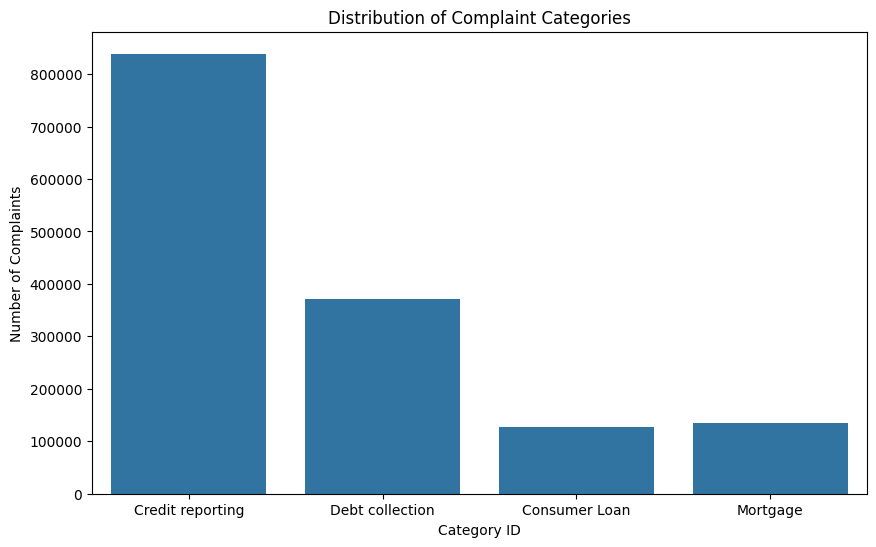


Shape of the filtered dataframe: (1472099, 2)
Class distribution:
 category_id
0    838863
1    371629
3    134837
2    126770
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('/kaggle/input/complaints-data/complaints.csv')

# --- 1.1 Data Exploration ---
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()

df = df[['Product', 'Consumer complaint narrative']].copy()

# Drop rows with missing complaints
df.dropna(subset=['Consumer complaint narrative'], inplace=True)

# --- 1.2 Feature Engineering (Mapping Categories) ---
category_map = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Credit reporting': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Student loan': 2,
    'Vehicle loan or lease': 2,
    'Payday loan, title loan, or personal loan': 2,
    'Mortgage': 3,
}

df_filtered = df[df['Product'].isin(category_map.keys())].copy()
df_filtered['category_id'] = df_filtered['Product'].map(category_map)
df_filtered = df_filtered[['Consumer complaint narrative', 'category_id']]

# --- 1.3 Visualize Class Distribution ---
plt.figure(figsize=(10, 6))
sns.countplot(x='category_id', data=df_filtered)
plt.title('Distribution of Complaint Categories')
plt.xlabel('Category ID')
plt.ylabel('Number of Complaints')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage'])
plt.show()

print("\nShape of the filtered dataframe:", df_filtered.shape)
print("Class distribution:\n", df_filtered['category_id'].value_counts())


In [ ]:
# --- 2. Text Pre-processing ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(preprocess_text)

print("\nSample of original vs. cleaned text:")
print("Original:", df_filtered['Consumer complaint narrative'].iloc[0])
print("Cleaned:", df_filtered['cleaned_narrative'].iloc[0])


Sample of original vs. cleaned text:
Original: These are not my accounts.
Cleaned: account


In [6]:
# --- 3.1 TF-IDF Vectorization ---
# Convert text data into numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df_filtered['cleaned_narrative']).toarray()
y = df_filtered['category_id']

# --- 3.2 Splitting the dataset ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nShape of training data (X_train):", X_train.shape)
print("Shape of testing data (X_test):", X_test.shape)

# --- 3.3 Initialize Models ---
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Linear SVC': LinearSVC(random_state=42)
}


Shape of training data (X_train): (1177679, 5000)
Shape of testing data (X_test): (294420, 5000)


In [7]:
# --- 4. Train and Compare Models ---
for name, model in models.items():
    print(f"--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage']))

--- Training Logistic Regression ---
Accuracy: 0.8882
Classification Report:
                  precision    recall  f1-score   support

Credit reporting       0.91      0.93      0.92    167773
 Debt collection       0.85      0.81      0.83     74326
   Consumer Loan       0.82      0.78      0.80     25354
        Mortgage       0.92      0.92      0.92     26967

        accuracy                           0.89    294420
       macro avg       0.87      0.86      0.87    294420
    weighted avg       0.89      0.89      0.89    294420

--- Training Multinomial Naive Bayes ---
Accuracy: 0.8550
Classification Report:
                  precision    recall  f1-score   support

Credit reporting       0.88      0.91      0.90    167773
 Debt collection       0.83      0.73      0.78     74326
   Consumer Loan       0.71      0.77      0.74     25354
        Mortgage       0.86      0.93      0.89     26967

        accuracy                           0.86    294420
       macro avg       0.

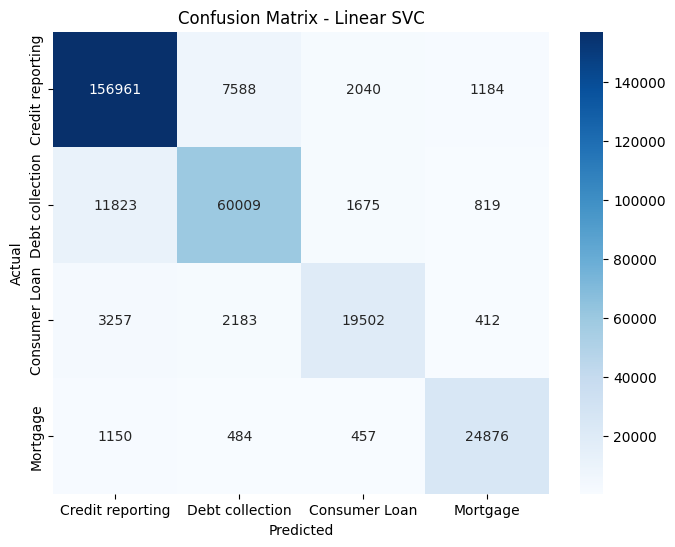

In [ ]:
# --- 5. Detailed Evaluation of the Best Model (assuming Linear SVC) ---
best_model = models['Linear SVC']
y_pred = best_model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage'],
            yticklabels=['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Linear SVC')
plt.show()

In [ ]:
# --- 6. Prediction on a New Complaint ---
def predict_category(complaint_text, model, vectorizer):

    cleaned_text = preprocess_text(complaint_text)
    
    text_vector = vectorizer.transform([cleaned_text])
    
    prediction = model.predict(text_vector)
    
    category_names = {0: 'Credit reporting', 1: 'Debt collection', 2: 'Consumer Loan', 3: 'Mortgage'}
    return category_names[prediction[0]]

new_complaint = "The debt collector will not stop calling my office and my home. I do not owe this debt!"

predicted_category = predict_category(new_complaint, best_model, tfidf_vectorizer)
print(f"\nNew Complaint: '{new_complaint}'")
print(f"Predicted Category: {predicted_category}")

new_complaint_2 = "I applied for a mortgage and the bank denied it, citing an incorrect item on my credit report."
predicted_category_2 = predict_category(new_complaint_2, best_model, tfidf_vectorizer)
print(f"\nNew Complaint: '{new_complaint_2}'")
print(f"Predicted Category: {predicted_category_2}")


New Complaint: 'The debt collector will not stop calling my office and my home. I do not owe this debt!'
Predicted Category: Debt collection

New Complaint: 'I applied for a mortgage and the bank denied it, citing an incorrect item on my credit report.'
Predicted Category: Credit reporting
